This notebook provides a minimal, self-contained demonstration of the `shap_bpt` library for pixel-wise explanation of image classifiers.
We load a pretrained model (like ResNet-50), define a masking-based black-box prediction function, specify simple background (baseline) images as replacement values, and use `shap_bpt` to compute Owen values with the BPT and the AA methods.
The goal is to clearly illustrate the essential workflow for generating and visualizing explanations.
Generated explanations are evaluated using simple response-based curves.

## Imports & library versions

In [1]:
# Core scientific / plotting libraries
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

# PyTorch + torchvision, image processing
import torch
from torchvision import transforms
from skimage.filters import gaussian

# ShapBPT
import shap_bpt as shap_bpt
print('shap_bpt version:',shap_bpt.__version__)

shap_bpt version: 1.0


## Device configuration (CPU / GPU / MPS)

In [2]:
use_cuda = torch.cuda.is_available()
use_mps = ('mps' in dir(torch.backends)) and torch.backends.mps.is_available()
torch.manual_seed(12345)

if use_cuda:    device = torch.device("cuda")
elif use_mps:   device = torch.device("mps")
else:           device = torch.device("cpu")
print('Using device:', device)

Using device: mps


## Utilities

In [3]:
def np_softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

## Black-box model and preprocessing

In [4]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)

# from torchvision.models import vit_b_16
# model = vit_b_16(weights='IMAGENET1K_V1').to(device)

# # # SWIN-ViT from timm
# from torchvision.models import swin_t
# model = swin_t(weights='IMAGENET1K_V1').to(device)

# import timm
# model = timm.create_model('vit_base_patch16_224', pretrained=True).to(device)

# from torchvision.models import vgg16
# model = vgg16(weights='IMAGENET1K_V1').to(device)


model.eval() # we are only doing inference
# Preprocessing
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
preprocess = transforms.Compose( # HWC [0,1] -> CHW normalized tensor
    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
)
normalize = transforms.Normalize(mean=mean, std=std)

# Black-box prediction function: takes a batch of tensors and returns logits (NumPy)
def bb_predict(x):
    with torch.no_grad():
        # return np_softmax(model(x), dim=1).cpu().detach().numpy()
        return model(x).cpu().detach().numpy()

## Load ImageNet class names

In [ ]:
# Load ImageNet class names (id -> human-readable label)
with open('imagenet_class_index.json') as file:
    class_names = [v[1] for v in json.load(file).values()]

## Helper to prepare one image (image-specific backgrounds & masking)

In [6]:
def prepare_image(image_path: str, target_size=(224, 224), seed: int = 0):
    """
    Loads an image, builds image-specific replacement backgrounds and a
    masking-based black-box wrapper nu_masked for shap_bpt.

    Returns a dict with all objects needed for explanation.
    """
    # --- Load and resize the image (BGR -> RGB) ---
    image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image_bgr is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb = cv2.resize(image_rgb, target_size)
    image_np = image_rgb.astype(np.uint8)  # HWC, uint8, [0..255]

    H, W, _ = image_np.shape

    # --- Preprocess for ResNet-50 ---
    image_tensor = preprocess(
        image_np.astype(np.float32) / 255.0
    ).unsqueeze(0).to(device)  # shape (1,3,H,W)

    # --- Image-specific replacement backgrounds ---
    # Black, gray, white
    bkgnd0 = np.full_like(image_np, 0)
    bkgnd1 = np.full_like(image_np, 127)
    bkgnd2 = np.full_like(image_np, 255)

    # Strongly blurred original
    bkgnd3 = (gaussian(image_np, sigma=8, channel_axis=-1) * 255).astype(np.uint8)

    # Smoothed random noise (same size as the image)
    rng = np.random.RandomState(seed)
    noise = rng.normal(loc=128, scale=128, size=image_np.shape)
    noise = np.clip(noise, 0, 255).astype(np.uint8)
    bkgnd4 = (gaussian(noise, sigma=2.0, channel_axis=-1) * 255).astype(np.uint8)

    # Stack backgrounds into one array
    background_image_set = np.stack([bkgnd0, bkgnd1, bkgnd2, bkgnd3, bkgnd4], axis=0)

    # Preprocess all backgrounds with the same transform as the main image
    background_tensors = torch.cat([preprocess(bkgnd.astype(np.float32) / 255.0).unsqueeze(0)
                                    for bkgnd in background_image_set
                                   ], dim=0).to(device)  # shape (B,3,H,W)

    # --- Image-specific masking-based prediction function ---
    def nu_masked(masks: np.ndarray) -> np.ndarray:
        """
        masks: Boolean NumPy array of shape (N, H, W)
               True  = keep original pixel
               False = replace with background pixel

        Returns: (N, num_classes) NumPy array of averaged logits.
        """
        N, Hm, Wm = masks.shape
        assert (Hm, Wm) == (H, W), "Mask size must match image size."

        B = background_tensors.shape[0]

        # Convert masks to a tensor and broadcast to (B*N, 3, H, W)
        masks_t = torch.from_numpy(masks).bool().to(device)  # (N,H,W)
        masks_t = masks_t.view(N, 1, H, W).repeat(1, 3, 1, 1)  # (N,3,H,W)
        masks_t = masks_t.unsqueeze(2).repeat(1, 1, B, 1, 1)   # (N,3,B,H,W)
        masks_t = masks_t.view(B * N, 3, H, W)                 # (B*N,3,H,W)

        # Tile original image and backgrounds to match masks
        Xf = image_tensor.repeat(B * N, 1, 1, 1)     # (B*N,3,H,W)
        Xb = background_tensors.repeat(N, 1, 1, 1)   # (B*N,3,H,W)

        # Apply masks: True -> keep original pixel, False -> background pixel
        X = torch.where(masks_t, Xf, Xb)

        # Use the global, image-agnostic black-box function
        logits = bb_predict(X)  # (B*N, num_classes)

        # Average over backgrounds
        logits = logits.reshape(N, B, -1)  # (N,B,num_classes)
        return logits.mean(axis=1)         # (N,num_classes)

    # --- Predict the class for the full (unmasked) image ---
    logits_full = bb_predict(image_tensor)[0]     # (num_classes,)
    probs_full = np_softmax(logits_full)
    pred_class = int(np.argmax(probs_full))

    print(
        f"{image_path}: predicted as '{class_names[pred_class]}' "
        f"with probability {probs_full[pred_class]:.4f}"
    )

    return {
        "image_path": image_path,
        "image_np": image_np,
        "image_tensor": image_tensor,
        "background_image_set": background_image_set,
        "background_tensors": background_tensors,
        "nu_masked": nu_masked,
        "logits_full": logits_full,
        "probs_full": probs_full,
        "predicted_class": pred_class,
    }

## Load image and visualize input and replacement values

flamingo4.png: predicted as 'flamingo' with probability 0.5045


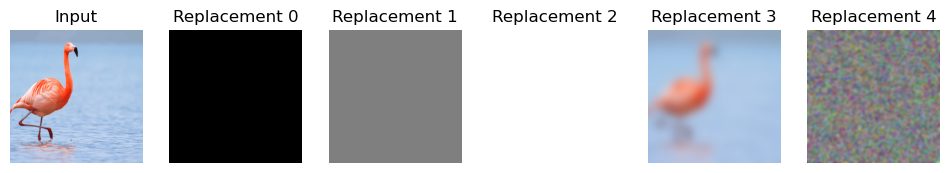

In [7]:
data = prepare_image("flamingo4.png")

fig,ax = plt.subplots(1,1+len(data["background_image_set"]), 
                      figsize=(2*(1+len(data["background_image_set"])), 2))
ax[0].imshow(data["image_np"])
ax[0].set_title('Input')
ax[0].set_axis_off()
for i,img in enumerate(data["background_image_set"]):
    ax[i+1].imshow(img.astype(np.uint8))
    ax[i+1].set_title(f'Replacement {i}')
    ax[i+1].set_axis_off()
plt.show()

## Configure explanation parameters

In [8]:
# How many black-box evaluations we are willing to pay for the explanation
MAX_EVALS_BUDGET = 100

# Batch size for evaluations within shap_bpt
batch_size = 4

# Number of top classes to explain (here: explain top-4 classes)
num_explained_classes = 4

In [ ]:
# Create the shap_bpt explainer using our masking-based black-box function
explainer = shap_bpt.Explainer(data["nu_masked"], data["image_np"],
                               num_explained_classes=num_explained_classes, verbose=True)

## Run shap_bpt with method = "BPT" (Binary Partition Tree)

In [ ]:
# Compute Owen values with the BPT method
shap_values_bpt = explainer.explain_instance(MAX_EVALS_BUDGET, method='BPT',
                                             batch_size=batch_size)

  0%|          | 0/100 [00:00<?, ?it/s]

## Visualize the Owen values (BPT explanation)

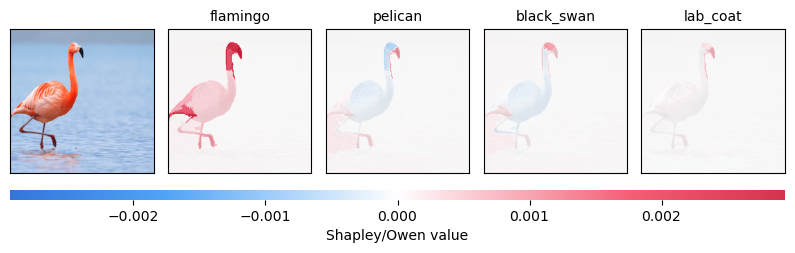

In [10]:
shap_bpt.plot_owen_values(explainer, shap_values_bpt, class_names)

## Sanity check: Owen values sum to nu(S) − nu(∅)

In [11]:
print('Expected Shapley explanation: ', explainer.base_f_S[0] - explainer.base_f_0[0])
print('Computed Shapley explanation: ', np.sum(shap_values_bpt[0]))

Expected Shapley explanation:  6.482598960399628
Computed Shapley explanation:  6.482598960399629


## Run shap_bpt with method = "AA" (Axis-Aligned partitions)

In [ ]:
shap_values_aa = explainer.explain_instance(MAX_EVALS_BUDGET, method='AA', verbose_plot=False, 
                                            batch_size=batch_size)

  0%|          | 0/100 [00:00<?, ?it/s]

# Visualize the Owen values side by side

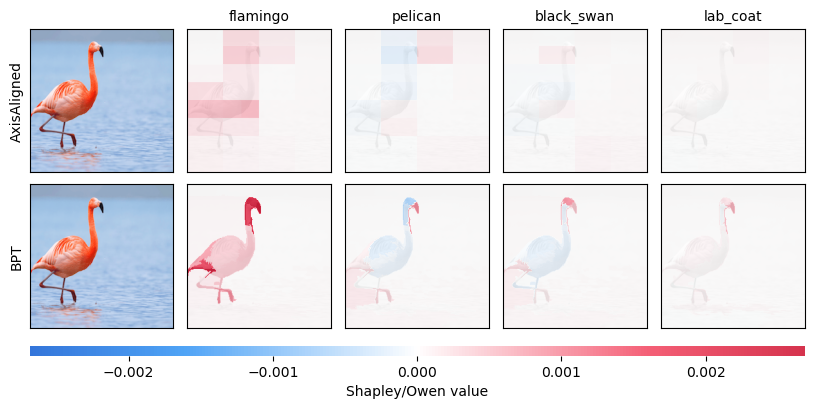

In [13]:
shap_bpt.plot_owen_values(explainer, [shap_values_aa,shap_values_bpt], 
                          class_names, names=['AxisAligned','BPT'])

In [14]:
print('Expected Shapley explanation: ', explainer.base_f_S[0] - explainer.base_f_0[0])
print('Computed Shapley explanation: ', np.sum(shap_values_aa[0]))

Expected Shapley explanation:  6.482598960399628
Computed Shapley explanation:  6.482598960399627


# Evaluation with response-based scores
Using Insertion (AUC+) and Deletion (AUC-) scores from (Petsiuk, Das and Saenko 2018)

In [15]:
def saliency_to_auc(nu, heatmap, f_S, f_0, predicted_cls, batch_size=4, method='del', num_samples=101, 
                    rule='trapezoid'):
    assert isinstance(heatmap, np.ndarray)
    assert len(heatmap.shape)==2 and np.issubdtype(heatmap.dtype, np.floating)

    xs, ys, ms, masks, qs = [], [], [], [], []
    for i, value in enumerate(np.linspace(start=1.0, stop=0.0, num=num_samples)):
        if method=='del':
            epsilon = (1 if value==0.0 else 0)
            q = (np.quantile(heatmap, q=value) - epsilon)
            m = heatmap <= q
            nx = (1.0 - np.sum(m) / m.size)
        elif method=='ins':
            epsilon = (1 if value==1.0 else 0)
            q = (np.quantile(heatmap, q=value) + epsilon)
            m = heatmap >= q
            nx = (np.sum(m) / m.size)
        else:
            raise Exception()
            
        # add a new datapoint on the curve
        if len(xs)==0 or nx != xs[-1]: 
            assert m.dtype==bool and len(m.shape)==2
            xs.append(nx)
            masks.append(m)
            ms.append(np.sum(heatmap[m]))
            qs.append(q)

        # evaluate the characteristic function
        if len(masks) >= batch_size or (len(masks)>0 and i==(num_samples-1)):
            y = nu(np.array(masks))[:, predicted_cls]
            ys.extend(y)
            masks = []

    assert len(masks)==0    
    xs, ys = np.array(xs), np.array(ys)
    assert(len(xs) == len(ys))

    # compute considering under/over shoots
    if f_S > f_0:
        overshoot_max = np.maximum(0, ys - f_S) # overshoot for values exceeding the maximum f(S)
        overshoot_min = np.maximum(0, f_0 - ys) # overshoot for values below the minimum f(0)
    else: # f(S) < f(0)
        overshoot_max = np.maximum(0, ys - f_0) # overshoot for values exceeding the maximum f(0)
        overshoot_min = np.maximum(0, f_S - ys) # overshoot for values below the minimum f(S)

    # clip ys, no oveshoots
    y_clipped = np.clip(ys, min(f_S, f_0), max(f_S, f_0))
    # adjust ys with the overshoot. Clip it inside the admitted range
    y_adjusted = np.clip(ys - 2*overshoot_max + 2*overshoot_min, min(f_S, f_0), max(f_S, f_0))

    # rebase to f(0)
    if f_S > f_0:
        flipped = False
        ys = ys - f_0 
        y_clipped = y_clipped - f_0 
        y_adjusted = y_adjusted - f_0
    else: # f(S) < f(0)
        flipped = True
        ys = f_0 - ys 
        y_clipped = f_0 - y_clipped 
        y_adjusted = f_0 - y_adjusted

    # rescaling
    ys_rescaled = ys / abs(f_S - f_0)
    y_clipped_rescaled = y_clipped / abs(f_S - f_0)
    y_adjusted_rescaled = y_adjusted / abs(f_S - f_0)

    auc, auc_r, auc_mae, auc_mse, auc_adj, auc_adjr, auc_clip, auc_clipr = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    curve_range = range(1, len(xs)) if rule=='trapezoid' else range(len(xs))

    # compute the area under the curve with the midpoint Riemann sum (i.e. the trapezoidal rule)
    for i in curve_range:
        if rule=='trapezoid':
            delta_x = abs(xs[i] - xs[i-1])
            assert delta_x > 0
            y_mid   =         0.5*(ys[i-1] + ys[i])
            y_r_mid =         0.5*(ys_rescaled[i-1] + ys_rescaled[i])
            err_mid = y_mid - 0.5*(ms[i-1] - ms[i])
            y_clip_mid =       0.5*(y_clipped[i-1] + y_clipped[i])
            y_clipr_mid =      0.5*(y_clipped_rescaled[i-1] + y_clipped_rescaled[i])
            y_adj_mid =       0.5*(y_adjusted[i-1] + y_adjusted[i])
            y_adjr_mid =      0.5*(y_adjusted_rescaled[i-1] + y_adjusted_rescaled[i])
        else: # rectangles
            delta_x = 1.0/num_samples if i==len(xs)-1 else abs(xs[i+1] - xs[i])
            assert delta_x > 0
            y_mid   =         ys[i]
            y_r_mid =         ys_rescaled[i]
            err_mid = y_mid - ms[i]
            y_clip_mid =       y_clipped[i]
            y_clipr_mid =      y_clipped_rescaled[i]
            y_adj_mid =       y_adjusted[i]
            y_adjr_mid =      y_adjusted_rescaled[i]


        auc += abs(delta_x * y_mid) # base * height
        auc_r += abs(delta_x * y_r_mid) # base * height
        auc_mae += abs(delta_x * err_mid) # base * height
        auc_mse += abs(delta_x * (err_mid**2)) # base * height^2
        auc_clip += abs(delta_x * y_clip_mid)
        auc_clipr += abs(delta_x * y_clipr_mid)
        auc_adj += abs(delta_x * y_adj_mid)
        auc_adjr += abs(delta_x * y_adjr_mid)

    return {'xs':xs, 'ms':ms, 'qs':qs, 
            'f_0':f_0, 'f_S':f_S, 'flipped':flipped, 
            'ys':ys, 'ysr':ys_rescaled,
            'y_clip':y_clipped, 'y_clipr':y_clipped_rescaled, 
            'y_adj':y_adjusted, 'y_adjr':y_adjusted_rescaled, 
            'method':method, 'predicted_cls':predicted_cls,
            'auc':auc, 'auc_r':auc_r,
            'auc_mae':auc_mae, 'auc_mse':auc_mse, 'auc_rmse':np.sqrt(auc_mse), 
            'auc_clip':auc_clip, 'auc_clipr':auc_clipr,
            'auc_adj':auc_adj, 'auc_adjr':auc_adjr}

In [17]:
predicted_cls = explainer.output_indexes[0]
f_S = explainer.base_f_S[0]
f_0 = explainer.base_f_0[0]
aucD_aa = saliency_to_auc(data["nu_masked"], shap_values_aa[0], f_S, f_0, predicted_cls, method='del')
aucD_bpt = saliency_to_auc(data["nu_masked"], shap_values_bpt[0], f_S, f_0, predicted_cls, method='del')
aucI_aa = saliency_to_auc(data["nu_masked"], shap_values_aa[0], f_S, f_0, predicted_cls, method='ins')
aucI_bpt = saliency_to_auc(data["nu_masked"], shap_values_bpt[0], f_S, f_0, predicted_cls, method='ins')

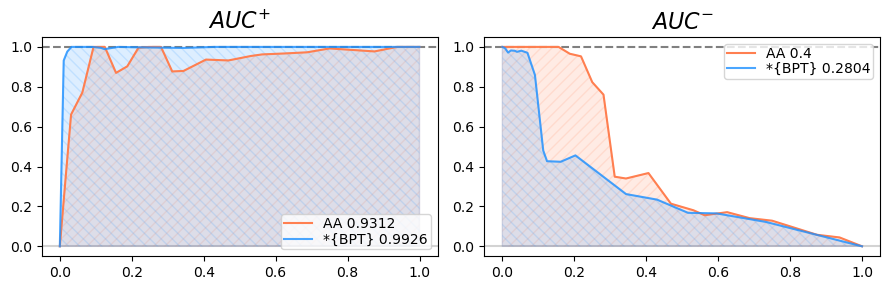

In [18]:
fig,axes = plt.subplots(1,2, figsize=(9,3), sharex=True)
for i in range(2):
    ax = axes.flat[i]
    if i==0: # AUC+
        title='$\\mathit{AUC}^{+}$'
        Xa,Ya,Ma,La = aucI_aa['xs'], aucI_aa['y_clipr'], aucI_aa['ms'], aucI_aa['auc_clipr']
        Xb,Yb,Mb,Lb = aucI_bpt['xs'], aucI_bpt['y_clipr'], aucI_bpt['ms'], aucI_bpt['auc_clipr']
    elif i==1: # AUC-
        title='$\\mathit{AUC}^{-}$'
        Xa,Ya,Ma,La = aucD_aa['xs'], aucD_aa['y_clipr'], aucD_aa['ms'], aucD_aa['auc_clipr']
        Xb,Yb,Mb,Lb = aucD_bpt['xs'], aucD_bpt['y_clipr'], aucD_bpt['ms'], aucD_bpt['auc_clipr']

    Sa, Sb = ('*', '') if La<Lb else ('', '*')
    if i in [0,2]:   Sa,Sb=Sb,Sa
    ax.plot(Xa, Ya, c='coral', label=f'{Sa}AA {La:.4}')
    ax.fill_between(Xa, Ya, color='coral', alpha=0.15, hatch='///')
    ax.plot(Xb, Yb, c='dodgerblue', label=f'{Sb}{{BPT}} {Lb:.4}', alpha=0.80)
    ax.fill_between(Xb, Yb, color='dodgerblue', alpha=0.15, hatch='\\\\\\')
    
    ax.axhline(1.0, ls='--', c='grey', zorder=0)
    
    ax.axhline(0, c='lightgrey', zorder=0)
    ax.legend(borderpad=0.2, labelspacing=0.1, loc='upper right' if i>=1 else 'lower right')
    ax.set_title(title, fontsize=16)

plt.tight_layout()
plt.show()